In [3]:
import pandas as pd
import seaborn as sns
# from sklearn.model_selection import train_test_split, cross_val_score

from skrules import SkopeRules # in skope_rules.py, from sklearn.externals import six must be changed with import six. Also there, you have to change from collections import Counter, Iterable must be changed
# with from collections import Counter and from collections.abc import Iterable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import joblib
import matplotlib.pyplot as plt
import os
from os.path import exists

from utilsData import *
from SkopeAlgorithm import *
from UtilsModel import *

import warnings as w
w.filterwarnings('ignore')

ImportError: cannot import name 'ComplexWarning' from 'numpy.core.numeric' (/mnt/c/Users/cimagroup/Documents/Repositorios/ExplainableSafetyRegions/entorno/lib/python3.10/site-packages/numpy/core/numeric.py)

In [2]:
data_path = "simulationVictor/"
datafilename = "dataset.csv"

res_path = "simulationVictor/skope/"
if not exists(res_path):
    os.mkdir(res_path)
    
output = "output"

# Train, test, calibration loading

In [3]:
# Verifica si el archivo existe en la carpeta
if os.path.exists(os.path.join(data_path, "train.csv")):
    print("Train.csv exists")
else:
    data = pd.read_csv(data_path+datafilename)
    n_tr = 4000
    n_ts = 1000
    n_c = 5000
    split_dataset(data.iloc[:,0:3].values,data.iloc[:,3].values,n_tr,n_ts,n_c,save_path=data_path)


Train.csv exists


In [4]:
train = pd.read_csv(data_path+"train.csv")
y_train = train[output]
X_train = train.drop([output],axis = 1)

calib = pd.read_csv(data_path+"calib.csv")
y_cal = calib[output]
X_cal = calib.drop(["output"],axis = 1)

test = pd.read_csv(data_path+"test.csv")
y_test = test[output]
X_test = test.drop([output],axis = 1)


# Skope Rules for output = 1 (collision class)

In [1]:
param_grid = [{"n_estimators":[10,50,100],"max_depth_duplication":[2,3,5,7], "precision_min":[0.5, 0.6,0.7,0.8,0.9]}]# list of dicts with different parameters (chosen between SkopeRules ones)


bestmodel = OptimizedSkopeRules(X_train, y_train, param_grid, cvmetric="f1", save_rules = False, rules_path = res_path+"skope_rules_collisions.csv", save_model = False, save_path = res_path+"skope_best_collisions.sav")


NameError: name 'OptimizedSkopeRules' is not defined

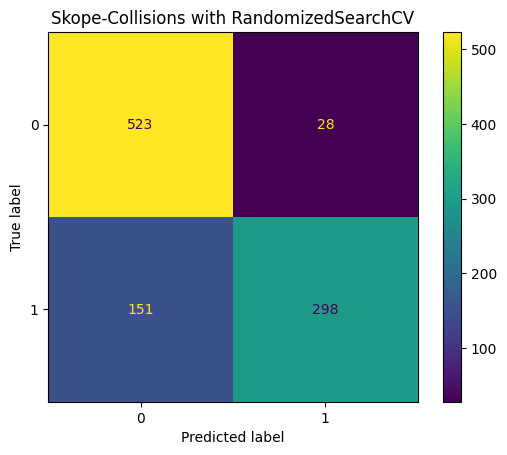

ACC = 0.821, F1 = 0.7690322580645161, PPV = 0.9141104294478528, NPV = 0.7759643916913946, TPR = 0.6636971046770601, TNR = 0.9491833030852994

TP = 298, FP = 28, TN = 523, FN= 151


In [5]:
EvaluateModel(bestmodel, X_test, y_test, "Skope-Collisions")


# Skope rules for output = 0 (non collision)

Swap labels to denote non collisions with 1


In [6]:
y_train = 1-y_train
y_test = 1-y_test
y_cal = 1- y_cal

In [7]:
# parameters optimization with RandomizedCV

param_grid = [{"n_estimators":[10,50,100],"max_depth_duplication":[2,3,5,7], "precision_min":[0.5, 0.6,0.7,0.8,0.9]}]# list of dicts with different parameters (chosen between SkopeRules ones)


bestmodel = OptimizedSkopeRules(X_train, y_train, param_grid, cvmetric="f1", save_rules = False, rules_path = res_path+"skope_rules_noncollisions.csv", save_model = False, save_path = res_path+"skope_best_noncollisions.sav")


Time spent for Randomized Search:  229.05341792106628  s
0.7197747672748755 {'precision_min': 0.9, 'n_estimators': 10, 'max_depth_duplication': 3}
0.8116919582438588 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 2}
0.7275742477665298 {'precision_min': 0.8, 'n_estimators': 100, 'max_depth_duplication': 2}
0.7674083602236189 {'precision_min': 0.9, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8071975016701367 {'precision_min': 0.7, 'n_estimators': 50, 'max_depth_duplication': 2}
0.8639959218430386 {'precision_min': 0.6, 'n_estimators': 100, 'max_depth_duplication': 5}
0.8581585980334385 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8642907077441222 {'precision_min': 0.5, 'n_estimators': 10, 'max_depth_duplication': 5}
0.8639959218430386 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 5}
0.8639959218430386 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 7}
SkopeRules best parameters with Rand

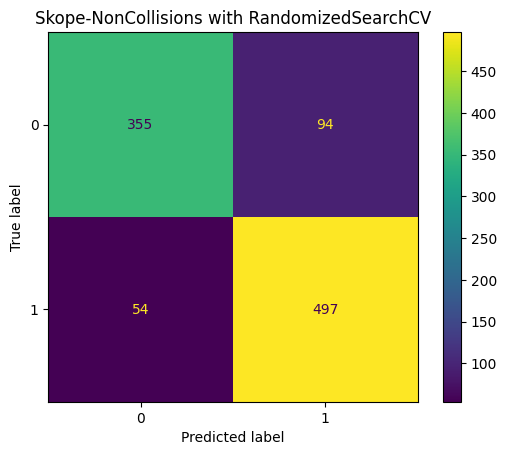

ACC = 0.852, F1 = 0.8704028021015762, PPV = 0.8409475465313029, NPV = 0.8679706601466992, TPR = 0.9019963702359347, TNR = 0.7906458797327395

TP = 497, FP = 94, TN = 355, FN= 54


In [8]:
EvaluateModel(bestmodel, X_test, y_test, "Skope-NonCollisions")